In [1]:
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
from typing import Callable, Optional
import numpy as np
from matplotlib import colors
import matplotlib.pyplot as plt
import thinker
import thinker.viz_utils as viz
import thinker.util as util
import gym
import gym_sokoban
import torch.nn.functional as F
import pandas as pd
import numpy as np
from celluloid import Camera
from thinker.actor_net import DRCNet
import os
import random
from thinker.actor_net import sample
from actpatchdrc import ActPatchDRCNet
import ast
import seaborn as sns

/home/tom/mlmi/dissertation/working_venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-07-23 13:24:10,773	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.



In [2384]:
env_n = 1 # batch size of the environment; can be increased to like 128 if using GPU
gpu = False # change to True for using GPU instead of CPU
mini_sokoban = True # if True, use mini-sokoban board (i.e. board is 8x8x7 array)

env = thinker.make(
    "Sokoban-medium-v0", 
    env_n=env_n, 
    gpu=gpu,
    wrapper_type=1, # wrapper_type 1 means default environment without Thinker-augmentation
    has_model=False, # the following arg are mainly for Thinker-augmentation only
    train_model=False, 
    parallel=False, 
    save_flags=False,
    mini=mini_sokoban, 
    mini_unqtar = False,
    mini_unqbox=False    
    ) 

flags = util.create_setting(args=[], save_flags=False, wrapper_type=1) # the default flags; almost all of them won't be used in DRC
flags.mini = True
flags.mini_unqtar = False
flags.mini_unqbox = False
drc_net = DRCNet(
    obs_space=env.observation_space,
    action_space=env.action_space,
    flags=flags,
    record_state=True,
    )
drc_net.to(env.device)

# now let load a trained DRC agent
import os
ckp_path = "../drc_mini"
ckp_path = os.path.join(util.full_path(ckp_path), "ckp_actor_realstep249000192.tar")
ckp = torch.load(ckp_path, env.device)
drc_net.load_state_dict(ckp["actor_net_state_dict"], strict=False)

# create list to store agent+env states
agent_env_list = []
rnn_state = drc_net.initial_state(batch_size=env_n, device=env.device)
state = env.reset() 
env_out = util.init_env_out(state, flags, dim_actions=1, tuple_action=False) # this converts the state to EnvOut object that can be processed by actor
actor_out, rnn_state = drc_net(env_out, rnn_state) # actor_out contains both the critic and actor output of DRC
state, reward, done, info = env.step(actor_out.action)

Initializing env 0 with device cpu


Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


In [729]:
thinking_time =2
thinking_mode = False

False


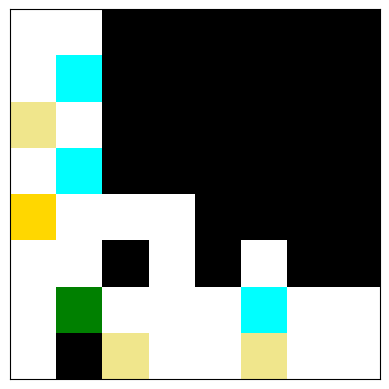

In [2383]:

env_out = util.create_env_out(actor_out.action, state, reward, done, info, flags)
with torch.no_grad():
    actor_out, rnn_state = drc_net(env_out, rnn_state, greedy=True)
agent_loc = (state["real_states"][0][4] == 1).to(int).argmax() 
agent_x, agent_y = agent_loc % 8, (agent_loc -(agent_loc % 8))//8

action = actor_out.action[0].item()
if action == 1 and agent_y > 1:
    if  state["real_states"][0][2,agent_y-1,agent_x] == 1:
        thinking_mode = True
elif action == 2 and agent_y < 6:
    if state["real_states"][0][2,agent_y+1,agent_x] == 1:
        thinking_mode = True
elif action == 3 and agent_x > 1:
    if state["real_states"][0][2,agent_y,agent_x-1] == 1:
        thinking_mode = True
elif action == 4 and agent_x < 6:
    if state["real_states"][0][2,agent_y,agent_x+1] == 1:
        thinking_mode = True

print(thinking_mode)
if thinking_mode:
    for thinking_step in range(20):
        print(f"{thinking_step=}")
        with torch.no_grad():
            actor_out, rnn_state = drc_net(env_out, rnn_state, greedy=True)
    thinking_mode = False
state, reward, done, info = env.step(actor_out.action)
viz.plot_mini_sokoban(state["real_states"][0])

In [8]:
solve_count = 0
all_count = 0
step_count = 0
rnn_state = drc_net.initial_state(batch_size=env_n, device=env.device)
state = env.reset() 
env_out = util.init_env_out(state, flags, dim_actions=1, tuple_action=False) # this converts the state to EnvOut object that can be processed by actor
actor_out, rnn_state = drc_net(env_out, rnn_state)
state, reward, done, info = env.step(actor_out.action)
thinking_time = 5

In [2409]:
results = []
num_eps = 50
for thinking_time in [0,1,2,3,4,5]:
    levs = []
    env = thinker.make(
    "Sokoban-medium-v0", 
        env_n=env_n, 
        gpu=gpu,
        wrapper_type=1, # wrapper_type 1 means default environment without Thinker-augmentation
        has_model=False, # the following arg are mainly for Thinker-augmentation only
        train_model=False, 
        parallel=False, 
        save_flags=False,
        mini=mini_sokoban, 
        mini_unqtar = False,
        mini_unqbox=False    
    ) 
    solve_count = 0
    all_count = 0
    step_count = 0
    rnn_state = drc_net.initial_state(batch_size=env_n, device=env.device)
    state = env.reset() 
    env_out = util.init_env_out(state, flags, dim_actions=1, tuple_action=False) # this converts the state to EnvOut object that can be processed by actor
    actor_out, rnn_state = drc_net(env_out, rnn_state)
    state, reward, done, info = env.step(actor_out.action)
    while all_count < num_eps:
        env_out = util.create_env_out(actor_out.action, state, reward, done, info, flags)
        with torch.no_grad():
            actor_out, rnn_state = drc_net(env_out, rnn_state, greedy=True)

        agent_loc = (state["real_states"][0][4] == 1).to(int).argmax() 
        thinking_mode = False
        agent_x, agent_y = agent_loc % 8, (agent_loc -(agent_loc % 8))//8

        action = actor_out.action[0].item()

        if action == 1 and agent_y > 1:
            if (state["real_states"][0][6,agent_y-2,agent_x] == 1 or state["real_states"][0][3,agent_y-2,agent_x] == 1) and state["real_states"][0][2,agent_y-1,agent_x] == 1:
                thinking_mode = True
        elif action == 2 and agent_y < 6:
            if (state["real_states"][0][6,agent_y+2,agent_x] == 1 or state["real_states"][0][3,agent_y+2,agent_x] == 1) and state["real_states"][0][2,agent_y+1,agent_x] == 1:
                thinking_mode = True
        elif action == 3 and agent_x > 1:
            if (state["real_states"][0][6,agent_y,agent_x-2] == 1 or state["real_states"][0][3,agent_y,agent_x-2] == 1)and state["real_states"][0][2,agent_y,agent_x-1] == 1:
                thinking_mode = True
        elif action == 4 and agent_x < 6:
            if (state["real_states"][0][6,agent_y,agent_x+2] == 1 or state["real_states"][0][3,agent_y,agent_x+2] == 1) and state["real_states"][0][2,agent_y,agent_x+1] == 1:
                thinking_mode = True

        if thinking_mode:
            for thinking_step in range(thinking_time):
                #print(f"{thinking_step=}")#
                with torch.no_grad():
                    actor_out, rnn_state = drc_net(env_out, rnn_state, greedy=True)
            thinking_mode = False

        state, reward, done, info = env.step(actor_out.action)
        step_count += 1
        #viz.plot_mini_sokoban(state["real_states"][0])
        if done:
            print(f"{all_count=}")
            if step_count < 110:
                solve_count += 1
                levs.append(all_count)
            all_count += 1
            step_count = 0
    results.append({thinking_time: (solve_count, levs)})

Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


all_count=0
all_count=1
all_count=2
all_count=3
all_count=4
all_count=5
all_count=6
all_count=7
all_count=8
all_count=9
all_count=10
all_count=11
all_count=12
all_count=13
all_count=14
all_count=15
all_count=16
all_count=17
all_count=18
all_count=19
all_count=20
all_count=21
all_count=22
all_count=23
all_count=24
all_count=25
all_count=26
all_count=27
all_count=28
all_count=29
all_count=30
all_count=31
all_count=32
all_count=33
all_count=34
all_count=35
all_count=36
all_count=37
all_count=38
all_count=39
all_count=40
all_count=41
all_count=42
all_count=43
all_count=44
all_count=45
all_count=46
all_count=47
all_count=48


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


all_count=49
all_count=0
all_count=1
all_count=2
all_count=3
all_count=4
all_count=5
all_count=6
all_count=7
all_count=8
all_count=9
all_count=10
all_count=11
all_count=12
all_count=13
all_count=14
all_count=15
all_count=16
all_count=17
all_count=18
all_count=19
all_count=20
all_count=21
all_count=22
all_count=23
all_count=24
all_count=25
all_count=26
all_count=27
all_count=28
all_count=29
all_count=30
all_count=31
all_count=32
all_count=33
all_count=34
all_count=35
all_count=36
all_count=37
all_count=38
all_count=39
all_count=40
all_count=41
all_count=42
all_count=43
all_count=44
all_count=45
all_count=46
all_count=47
all_count=48


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


all_count=49
all_count=0
all_count=1
all_count=2
all_count=3
all_count=4
all_count=5
all_count=6
all_count=7
all_count=8
all_count=9
all_count=10
all_count=11
all_count=12
all_count=13
all_count=14
all_count=15
all_count=16
all_count=17
all_count=18
all_count=19
all_count=20
all_count=21
all_count=22
all_count=23
all_count=24
all_count=25
all_count=26
all_count=27
all_count=28
all_count=29
all_count=30
all_count=31
all_count=32
all_count=33
all_count=34
all_count=35
all_count=36
all_count=37
all_count=38
all_count=39
all_count=40
all_count=41
all_count=42
all_count=43
all_count=44
all_count=45
all_count=46
all_count=47
all_count=48


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


all_count=49
all_count=0
all_count=1
all_count=2
all_count=3
all_count=4
all_count=5
all_count=6
all_count=7
all_count=8
all_count=9
all_count=10
all_count=11
all_count=12
all_count=13
all_count=14
all_count=15
all_count=16
all_count=17
all_count=18
all_count=19
all_count=20
all_count=21
all_count=22
all_count=23
all_count=24
all_count=25
all_count=26
all_count=27
all_count=28
all_count=29
all_count=30
all_count=31
all_count=32
all_count=33
all_count=34
all_count=35
all_count=36
all_count=37
all_count=38
all_count=39
all_count=40
all_count=41
all_count=42
all_count=43
all_count=44
all_count=45
all_count=46
all_count=47
all_count=48


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


all_count=49
all_count=0
all_count=1
all_count=2
all_count=3
all_count=4
all_count=5
all_count=6
all_count=7
all_count=8
all_count=9
all_count=10
all_count=11
all_count=12
all_count=13
all_count=14
all_count=15
all_count=16
all_count=17
all_count=18
all_count=19
all_count=20
all_count=21
all_count=22
all_count=23
all_count=24
all_count=25
all_count=26
all_count=27
all_count=28
all_count=29
all_count=30
all_count=31
all_count=32
all_count=33
all_count=34
all_count=35
all_count=36
all_count=37
all_count=38
all_count=39
all_count=40
all_count=41
all_count=42
all_count=43
all_count=44
all_count=45
all_count=46
all_count=47
all_count=48


Initializing env 0 with device cpu
Init. environment with obs space Box(0, 1, (7, 8, 8), uint8) and action space Discrete(5)


all_count=49
all_count=0
all_count=1
all_count=2
all_count=3
all_count=4
all_count=5
all_count=6
all_count=7
all_count=8
all_count=9
all_count=10
all_count=11
all_count=12
all_count=13
all_count=14
all_count=15
all_count=16
all_count=17
all_count=18
all_count=19
all_count=20
all_count=21
all_count=22
all_count=23
all_count=24
all_count=25
all_count=26
all_count=27
all_count=28
all_count=29
all_count=30
all_count=31
all_count=32
all_count=33
all_count=34
all_count=35
all_count=36
all_count=37
all_count=38
all_count=39
all_count=40
all_count=41
all_count=42
all_count=43
all_count=44
all_count=45
all_count=46
all_count=47
all_count=48
all_count=49


In [2411]:
for i in [0,1,2,4,5]:
    print(results[i])

{0: (25, [0, 1, 2, 3, 6, 8, 12, 14, 15, 18, 19, 22, 28, 31, 32, 34, 37, 38, 39, 40, 41, 44, 46, 47, 48])}
{1: (26, [0, 1, 2, 3, 6, 8, 12, 14, 15, 18, 19, 22, 24, 26, 28, 31, 32, 34, 37, 38, 39, 40, 41, 44, 47, 48])}
{2: (26, [0, 1, 2, 3, 6, 8, 12, 14, 15, 18, 19, 22, 24, 26, 28, 31, 32, 34, 37, 38, 39, 40, 41, 44, 47, 48])}
{4: (28, [0, 1, 2, 3, 6, 8, 12, 14, 15, 18, 19, 22, 26, 27, 28, 31, 32, 34, 35, 37, 38, 39, 40, 41, 44, 45, 47, 48])}
{5: (27, [0, 1, 2, 3, 6, 8, 12, 14, 15, 18, 19, 22, 26, 27, 28, 31, 32, 34, 37, 38, 39, 40, 41, 44, 45, 47, 48])}
